In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model

import utils
import datetime
import os
np.random.seed(42)

#  XGBoost

Defining constants

In [109]:
person = 'Davis'
#person = 'JOURNEY HOUSE TRAVEL INC'
cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name', 'Cardholder First Initial'] + numeric_vars + cat_vars
num_rounds = 20
params = {
    'max_depth':         12,
    'max_leaves':        2**12,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [110]:
df = utils.get_df()

In [111]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]

Training model

In [112]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [113]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.67593	train-logloss:0.67418
[1]	test-logloss:0.66454	train-logloss:0.66082
[2]	test-logloss:0.65283	train-logloss:0.64695
[3]	test-logloss:0.64235	train-logloss:0.63592
[4]	test-logloss:0.63602	train-logloss:0.62802
[5]	test-logloss:0.63087	train-logloss:0.62176
[6]	test-logloss:0.62447	train-logloss:0.61344
[7]	test-logloss:0.62137	train-logloss:0.60896
[8]	test-logloss:0.61610	train-logloss:0.60290
[9]	test-logloss:0.61437	train-logloss:0.59975
[10]	test-logloss:0.60962	train-logloss:0.59315
[11]	test-logloss:0.60830	train-logloss:0.59077
[12]	test-logloss:0.60420	train-logloss:0.58479
[13]	test-logloss:0.60071	train-logloss:0.57798
[14]	test-logloss:0.59925	train-logloss:0.57524
[15]	test-logloss:0.59862	train-logloss:0.57380
[16]	test-logloss:0.59735	train-logloss:0.56942
[17]	test-logloss:0.59584	train-logloss:0.56698
[18]	test-logloss:0.59630	train-logloss:0.56570
[19]	test-logloss:0.59466	train-logloss:0.56238


Test Model

In [114]:
threshold = .5
true_labels = y_test.astype(int)
true_labels.sum()

277

In [115]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [116]:
pred_labels.sum()

425

In [117]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.7740551773748784
Accuracy: 0.6423357664233577


Confusion Matrix :


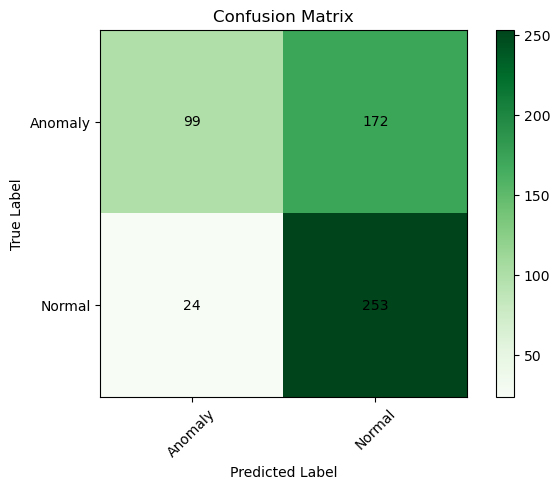

In [118]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

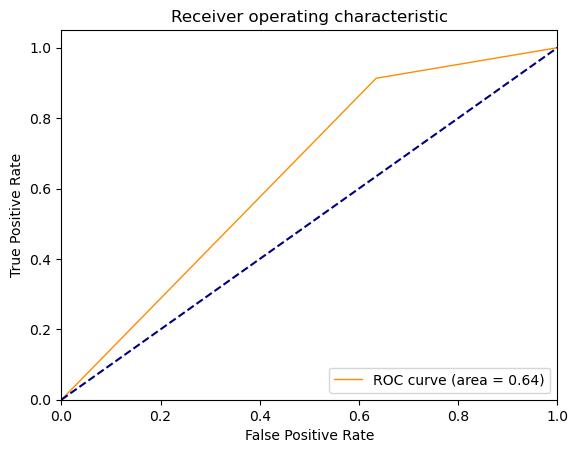

In [119]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

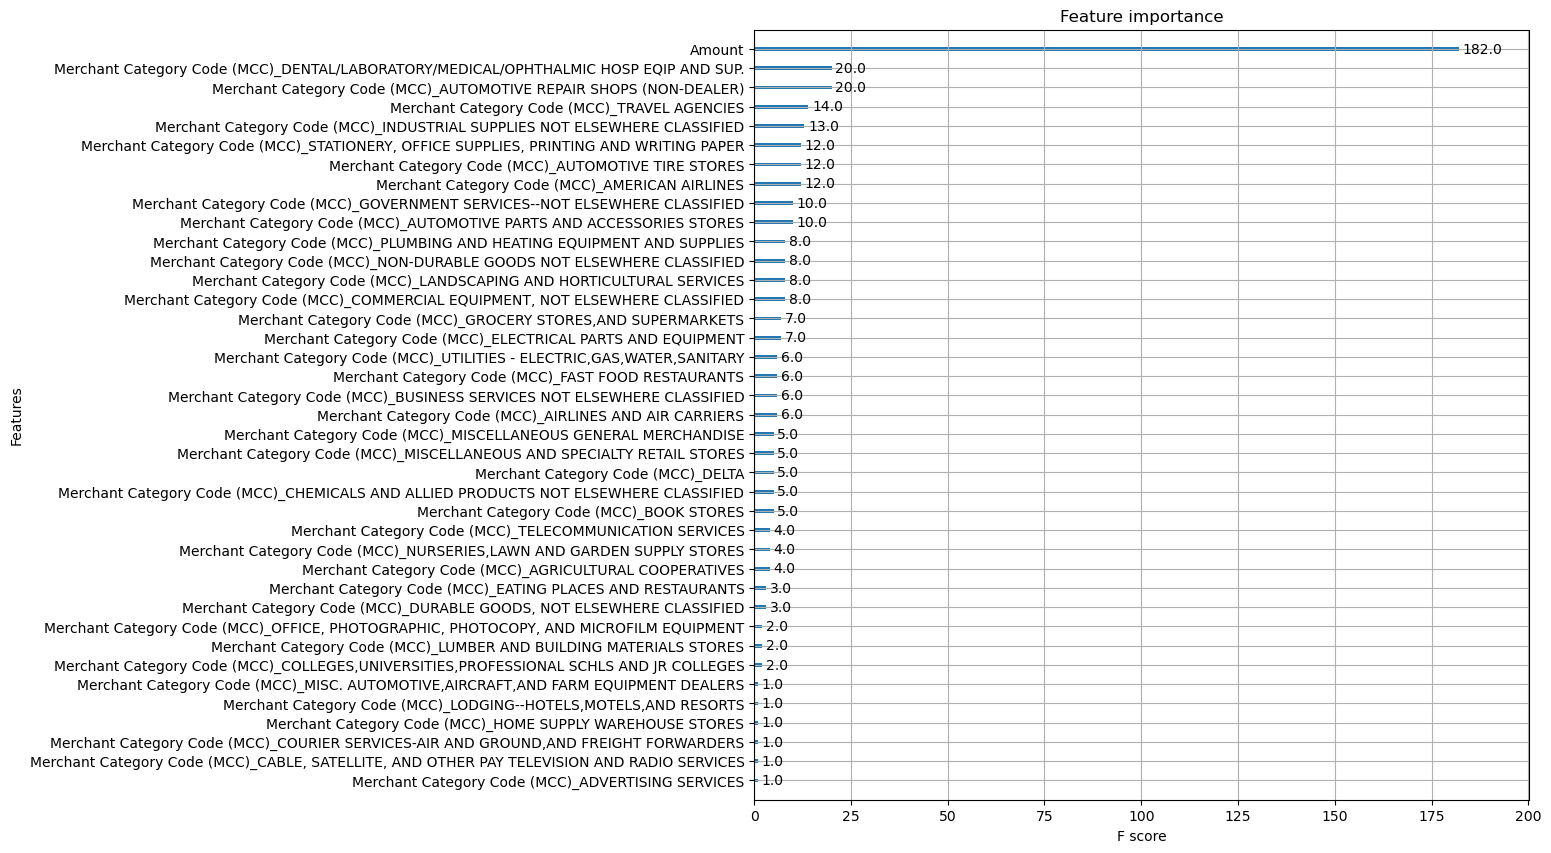

In [120]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

# Tunning Hyperparams

In [121]:
params = {
    'eta':               0.1,
    'gamma':             0.1,
    'max_depth':         12,
    'reg_alpha':             0.9,
    'subsample':         1,
    'learning_rate':     0.1,
    'reg_lambda':        1,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [170]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 6, 18, 1),
        'gamma': hp.uniform ('gamma', 0,20),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.2),
        'subsample': hp.uniform ('subsample', 0.1,1.0),
        'eta': hp.uniform ('eta', 0.01,0.2),        
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'n_estimators': 1800,
        'seed': 0
    }

In [171]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    eta = space['eta'],
                    reg_lambda = space['reg_lambda'],
                    subsample = space['subsample'],
                    learning_rate = space['learning_rate'],
                    reg_alpha = int(space['reg_alpha']),
                    eval_metric="auc",
                    early_stopping_rounds=10
                    )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train, eval_set=evaluation, verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.49452554744525545                                    
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                          

In [172]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.06582724197943171, 'gamma': 0.5042948228881563, 'learning_rate': 0.13090408753985017, 'max_depth': 17.0, 'reg_alpha': 55.0, 'reg_lambda': 0.8254806663371803, 'subsample': 0.7805981646275115}


In [173]:
params = {
    'max_depth':         17,
    'reg_alpha':         55,
    'eta':               0.066,
    'gamma':             0.5,
    'learning_rate':     0.13,
    'subsample':         .78,
    'reg_lambda':        .825,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [174]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [175]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.68493	train-logloss:0.68280
[1]	test-logloss:0.67917	train-logloss:0.67477
[2]	test-logloss:0.67347	train-logloss:0.66753
[3]	test-logloss:0.67275	train-logloss:0.66675
[4]	test-logloss:0.67275	train-logloss:0.66675
[5]	test-logloss:0.67275	train-logloss:0.66675
[6]	test-logloss:0.67275	train-logloss:0.66675
[7]	test-logloss:0.67070	train-logloss:0.66372
[8]	test-logloss:0.67070	train-logloss:0.66372
[9]	test-logloss:0.66816	train-logloss:0.66054
[10]	test-logloss:0.66816	train-logloss:0.66054
[11]	test-logloss:0.66816	train-logloss:0.66054
[12]	test-logloss:0.66735	train-logloss:0.65965
[13]	test-logloss:0.66735	train-logloss:0.65965
[14]	test-logloss:0.66735	train-logloss:0.65965
[15]	test-logloss:0.66735	train-logloss:0.65965
[16]	test-logloss:0.66735	train-logloss:0.65965
[17]	test-logloss:0.66676	train-logloss:0.65901
[18]	test-logloss:0.66676	train-logloss:0.65901
[19]	test-logloss:0.66676	train-logloss:0.65901


In [176]:
transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val_2 = transations_val_2[0][0]
labels_val_2 = transations_val_2[1][0]

In [177]:
dtest_val = xgb.DMatrix(df_transations_val_2, label=labels_val_2)

In [178]:
true_labels = y_test.astype(int)
preds_val = model.predict(dtest_val)
pred_labels_val = (preds_val > threshold).astype(int)

In [179]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.7740551773748784
Accuracy: 0.6423357664233577


Confusion Matrix :


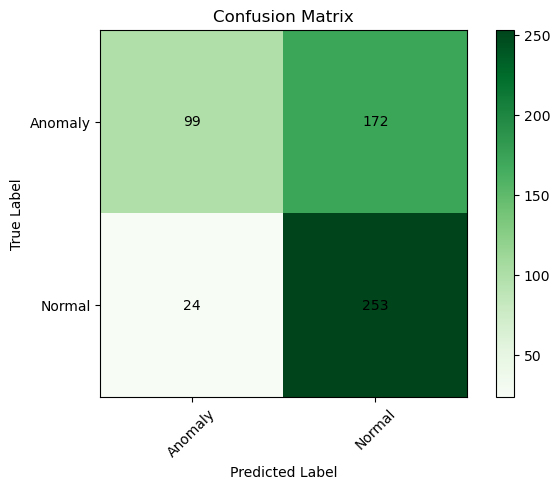

In [180]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

# Test for all persons

In [181]:
def calc_accuracy(name: str):
    # Train Model
    transations = utils.get_person_balanced_df(df, name, categories, cat_vars, numeric_vars)
    df_transations = transations[0][0]
    labels = transations[1][0]
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtest, 'test'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_rounds, evals=evals)
    #Validation
    #transations_val = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
    #df_transations_val = transations_val[0][0]
    #labels_val = transations_val[1][0]
    #dtest_val = xgb.DMatrix(df_transations_val, label=labels_val)
    #true_labels_val = labels_val.astype(int)
    preds = model.predict(dtest)
    pred_labels = (preds > threshold).astype(int)
    true_labels = y_test.astype(int)
    return accuracy_score(true_labels, pred_labels)

In [182]:
persons = list(df['Cardholder Last Name'].unique())
quantities = df['Cardholder Last Name'].value_counts()
values = []
names = []

for person in persons:
    if quantities[person] > 1000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

[0]	test-logloss:0.68854	train-logloss:0.68874
[1]	test-logloss:0.68854	train-logloss:0.68874
[2]	test-logloss:0.68365	train-logloss:0.68209
[3]	test-logloss:0.68365	train-logloss:0.68209
[4]	test-logloss:0.68365	train-logloss:0.68209
[5]	test-logloss:0.68365	train-logloss:0.68209
[6]	test-logloss:0.68365	train-logloss:0.68209
[7]	test-logloss:0.68365	train-logloss:0.68209
[8]	test-logloss:0.68365	train-logloss:0.68209
[9]	test-logloss:0.68365	train-logloss:0.68209
[10]	test-logloss:0.68365	train-logloss:0.68209
[11]	test-logloss:0.68365	train-logloss:0.68209
[12]	test-logloss:0.68365	train-logloss:0.68209
[13]	test-logloss:0.68365	train-logloss:0.68209
[14]	test-logloss:0.68365	train-logloss:0.68209
[15]	test-logloss:0.68365	train-logloss:0.68209
[16]	test-logloss:0.68365	train-logloss:0.68209
[17]	test-logloss:0.68365	train-logloss:0.68209
[18]	test-logloss:0.68365	train-logloss:0.68209
[19]	test-logloss:0.68365	train-logloss:0.68209
[0]	test-logloss:0.68409	train-logloss:0.68269
[1]

Text(0, 0.5, 'Accuracy')

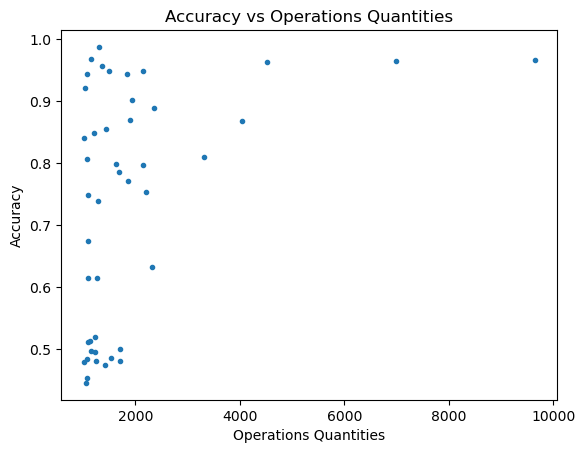

In [183]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")